# Train and run wflow_sbm surrogate model

The surrogate emulates Actual Evapotranspiration and Volumetric Water Content (top 10 cm) produced from Wflow_sbm over the Alpine region at 1 km spatial resolution and daily time steps. 

The repository offers a very small dataset in the demodata folder. Uncomment the jupyter notebook cell "DEMO" and comment the cell "ALPS" in order to train the model.

The figures at the end of the notebook show the surrogate outputs on the Alps, however the training data are not yet available to reproduce the results.

In [13]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.preprocess import apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.metrics import mse_metric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, missing_location_idx
from hython.models.lstm import CustomLSTM

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler


def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

# Settings

In [27]:
wflow_model =  "alps1km_eobs"

surrogate_experiment_name = "s000001" 

HIDDEN = 36
BATCH = 256

wd = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")

surrogate_data = wd / f"{wflow_model}.zarr"

# path to directory to save model weights after training
dp_surrogate_model = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model")

dynamic_names = ["precip", "pet", "temp"] #  WFLOW forcings, input features of the surrogate
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] # WFLOW static parameters, input features of the surrogate
target_names = [ "vwc","actevap"] # WFLOW outputs, targets of the surrogate

TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

remove_lakes = True

# sampler for spatial training/validation
spatial_sampling = True
intervals = (36, 36) # every n km
train_origin = (0, 0)
val_origin = (2, 2)


# training/validation  period 
train_start = "2016-01-01"
train_end = "2018-12-31"

train_range = slice(train_start,train_end)

In [28]:
if surrogate_experiment_name == "s0001": # 0.1 %
    print("0.1 %")
    intervals = [12, 12]
    val_origin = [1 ,1 ]
    train_origin = [0, 0]
if surrogate_experiment_name == "s0010":  # 1 %
    print("1 %")
    intervals = [4, 4]
    val_origin = [1, 1]
    train_origin = [0, 0]
if surrogate_experiment_name == "s00001":  # 0.01 %
    print("0.01 %")
    intervals = [36, 36]
    val_origin = [1, 1]
    train_origin = [0, 0]
if surrogate_experiment_name == "s000001":  # 0.001 %
    print("0.001 %")
    intervals = [108, 108]
    val_origin = [64, 64]
    train_origin = [0, 0]

0.001 %


In [29]:
# Read from preprocessed data, select train range

# train
Xd = read_from_zarr(url=surrogate_data, group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=surrogate_data, group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=surrogate_data, group="y", multi_index="gridcell").sel(time = train_range).y

# other 
wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
wflow_dem = Xs.sel(feat="wflow_dem").unstack()

# select features and targets 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

# read masks
mask_missing = read_from_zarr(url=surrogate_data, group="mask" ).mask
mask_lake = read_from_zarr(url=surrogate_data, group="mask_lake" ).mask_lake

spatial_batch_size = BATCH 
temporal_sampling_size = 150 
seq_length = 360 
hidden_size = HIDDEN

model_params={
    "input_size": len(dynamic_names), 
    "hidden_size": hidden_size, 
    "output_size": len(target_names),
    "number_static_predictors": len(static_names), 

}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.

if spatial_sampling:

    # training set
    spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)

    # validation set
    spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

    # Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
    data2d  = wflow_dem.values

    idx = missing_location_idx(Xs.values)
    
    sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, mask_missing)
    sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, mask_missing)

    # some useful metadata
    print(sampler_train_meta)

    # check location of training and validation sets
    #_ = plot_sampler(wflow_dem, sampler_train_meta, sampler_val_meta, figsize= (8, 8 ), markersize = 2)
else:
    idx = missing_location_idx(Xs)

    Xd_nomissing = Xd[~idx]
    Xs_nomissing = Xs[~idx]
    Y_nomissing = Y[~idx]

SamplerResult(
 - id_grid_2d: (689, 1177) 
 - idx_sampled_1d: (77,) 
 - idx_sampled_1d_nomissing: (31,)) 
 - idx_missing_1d: (431441,) 
 - sampled_grid_dims: (7, 11) 
 - xr_coords: None


In [31]:
print("Percentage of sampled data: ",(len(sampler_train_meta.idx_sampled_1d_nomissing)/ len(Xs[~idx].values.flatten()))*100, "%")

Percentage of sampled data:  0.001361397443734761 %


In [32]:
# # Normalizing

if spatial_sampling:

    # statistics from training set
    Xd[sampler_train_meta.idx_sampled_1d_nomissing], d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
    Xs[sampler_train_meta.idx_sampled_1d_nomissing], s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
    Y[sampler_train_meta.idx_sampled_1d_nomissing], y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

    # normalize training set and validation set
    Xd[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Xd[sampler_val_meta.idx_sampled_1d_nomissing], type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Xs[sampler_val_meta.idx_sampled_1d_nomissing], type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Y[sampler_val_meta.idx_sampled_1d_nomissing], type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()


else:
    _, d_m, d_std = apply_normalization(Xd_nomissing, type = "spacetime", how ='standard')
    _, s_m, s_std = apply_normalization(Xs_nomissing, type = "space", how ='standard')
    _, y_m, y_std = apply_normalization(Y_nomissing, type = "spacetime", how ='standard')

    Xd_nomissing = apply_normalization(Xd_nomissing, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_nomissing = apply_normalization(Xs_nomissing, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_nomissing = apply_normalization(Y_nomissing, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

    Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_test = apply_normalization(Xs_test, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

# Prepare Model inputs

In [33]:
if spatial_sampling:
    Xs = torch.Tensor(Xs.values)
    Xd = torch.Tensor(Xd.values)
    Y = torch.Tensor(Y.values)
    
    Xs.shape, Xd.shape, Y.shape

    # init datasets
    dataset = LSTMDataset(Xd, Y, Xs)
    
    train_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
    valid_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())
    
    train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
    val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)
else:
    Xs_nms = torch.Tensor(Xs_nomissing)
    Xd_nms = torch.Tensor(Xd_nomissing)
    Y_nms = torch.Tensor(Y_nomissing)

    # init datasets
    dataset = LSTMDataset(Xd_nms, Y_nms, Xs_nms)
    
    train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=True)
    

# Initialize Model

In [34]:
model = CustomLSTM(**model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=9, out_features=36, bias=True)
  (lstm): LSTM(36, 36, batch_first=True)
  (fc1): Linear(in_features=36, out_features=2, bias=True)
)

# Train/valid settings

In [36]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-3)


loss_fn = RMSELoss(target_weight={"actevap":0.333, "vwc":0.333, "runoff":0.333})
loss_fn = RMSELoss(target_weight={"actevap":0.5, "vwc":0.5})


metric_fn = mse_metric

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 90

In [12]:
params_train={
    "num_epochs": epochs,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": target_names

}

# Run Train/valid

In [13]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train)

  0%|                                                                                                         | 0/90 [00:00<?, ?it/s]

Epoch 0/89, current lr=0.001


  1%|█                                                                                                | 1/90 [00:01<02:38,  1.78s/it]

Copied best model weights!
train loss: 0.3452790081501007, train metric: {'vwc': 0.67059094, 'actevap': 0.5316456, 'runoff': 0.8953161}
val loss: 0.2936745584011078, val metric: {'vwc': 0.43651652, 'actevap': 0.42473802, 'runoff': 0.7457038}
----------
Epoch 1/89, current lr=0.001


  2%|██▏                                                                                              | 2/90 [00:03<02:27,  1.68s/it]

Copied best model weights!
train loss: 0.27024754881858826, train metric: {'vwc': 0.3485989, 'actevap': 0.36593553, 'runoff': 0.6075431}
val loss: 0.2545330822467804, val metric: {'vwc': 0.2903549, 'actevap': 0.28350127, 'runoff': 0.69425297}
----------
Epoch 2/89, current lr=0.001


  3%|███▏                                                                                             | 3/90 [00:05<02:23,  1.65s/it]

train loss: 0.2987312376499176, train metric: {'vwc': 0.27318025, 'actevap': 0.3812836, 'runoff': 1.0812982}
val loss: 0.2717808783054352, val metric: {'vwc': 0.26783562, 'actevap': 0.4104131, 'runoff': 0.92822546}
----------
Epoch 3/89, current lr=0.001


  4%|████▎                                                                                            | 4/90 [00:06<02:21,  1.64s/it]

Copied best model weights!
train loss: 0.24718211591243744, train metric: {'vwc': 0.25105652, 'actevap': 0.22758873, 'runoff': 0.9309608}
val loss: 0.23651836812496185, val metric: {'vwc': 0.2449206, 'actevap': 0.21224824, 'runoff': 0.80981123}
----------
Epoch 4/89, current lr=0.001


  6%|█████▍                                                                                           | 5/90 [00:08<02:20,  1.65s/it]

train loss: 0.25342556834220886, train metric: {'vwc': 0.24752827, 'actevap': 0.17195041, 'runoff': 1.2670947}
val loss: 0.24248458445072174, val metric: {'vwc': 0.25867, 'actevap': 0.18144621, 'runoff': 0.9726953}
----------
Epoch 5/89, current lr=0.001


  7%|██████▍                                                                                          | 6/90 [00:09<02:18,  1.65s/it]

Copied best model weights!
train loss: 0.2605494558811188, train metric: {'vwc': 0.215041, 'actevap': 0.257631, 'runoff': 1.2694088}
val loss: 0.23417115211486816, val metric: {'vwc': 0.21489777, 'actevap': 0.2351235, 'runoff': 0.974158}
----------
Epoch 6/89, current lr=0.001


  8%|███████▌                                                                                         | 7/90 [00:11<02:16,  1.64s/it]

train loss: 0.279133141040802, train metric: {'vwc': 0.22595751, 'actevap': 0.14107493, 'runoff': 1.7088882}
val loss: 0.26065072417259216, val metric: {'vwc': 0.2497212, 'actevap': 0.15732431, 'runoff': 1.4293258}
----------
Epoch 7/89, current lr=0.001


  9%|████████▌                                                                                        | 8/90 [00:13<02:14,  1.63s/it]

Copied best model weights!
train loss: 0.22778701782226562, train metric: {'vwc': 0.21027215, 'actevap': 0.15820716, 'runoff': 0.81570035}
val loss: 0.22913044691085815, val metric: {'vwc': 0.24475284, 'actevap': 0.17384228, 'runoff': 0.73580056}
----------
Epoch 8/89, current lr=0.001


 10%|█████████▋                                                                                       | 9/90 [00:14<02:12,  1.64s/it]

Copied best model weights!
train loss: 0.2335045337677002, train metric: {'vwc': 0.19145203, 'actevap': 0.15097474, 'runoff': 0.7916971}
val loss: 0.21523742377758026, val metric: {'vwc': 0.21050614, 'actevap': 0.17154458, 'runoff': 0.52387595}
----------
Epoch 9/89, current lr=0.001


 11%|██████████▋                                                                                     | 10/90 [00:16<02:10,  1.63s/it]

train loss: 0.23496641218662262, train metric: {'vwc': 0.18865521, 'actevap': 0.14400384, 'runoff': 0.85120225}
val loss: 0.2341153621673584, val metric: {'vwc': 0.2254738, 'actevap': 0.16052054, 'runoff': 0.7819839}
----------
Epoch 10/89, current lr=0.001


 12%|███████████▋                                                                                    | 11/90 [00:18<02:09,  1.63s/it]

Copied best model weights!
train loss: 0.2187335342168808, train metric: {'vwc': 0.17109036, 'actevap': 0.16012457, 'runoff': 0.7504975}
val loss: 0.20875048637390137, val metric: {'vwc': 0.18877181, 'actevap': 0.1803359, 'runoff': 0.51550347}
----------
Epoch 11/89, current lr=0.001


 13%|████████████▊                                                                                   | 12/90 [00:19<02:07,  1.64s/it]

train loss: 0.2140999585390091, train metric: {'vwc': 0.18246426, 'actevap': 0.10087572, 'runoff': 0.7202805}
val loss: 0.22262105345726013, val metric: {'vwc': 0.2266066, 'actevap': 0.12478748, 'runoff': 0.6770446}
----------
Epoch 12/89, current lr=0.001


 14%|█████████████▊                                                                                  | 13/90 [00:21<02:05,  1.63s/it]

train loss: 0.22023223340511322, train metric: {'vwc': 0.17484552, 'actevap': 0.12209371, 'runoff': 0.7975457}
val loss: 0.22449898719787598, val metric: {'vwc': 0.22253725, 'actevap': 0.15011139, 'runoff': 0.6502562}
----------
Epoch 13/89, current lr=0.001


 16%|██████████████▉                                                                                 | 14/90 [00:22<02:03,  1.63s/it]

train loss: 0.20630070567131042, train metric: {'vwc': 0.14975843, 'actevap': 0.11785873, 'runoff': 0.66940403}
val loss: 0.21075834333896637, val metric: {'vwc': 0.23090611, 'actevap': 0.13278936, 'runoff': 0.43973175}
----------
Epoch 14/89, current lr=0.001


 17%|████████████████                                                                                | 15/90 [00:24<02:02,  1.63s/it]

train loss: 0.19719620048999786, train metric: {'vwc': 0.14792776, 'actevap': 0.11345661, 'runoff': 0.59780777}
val loss: 0.22203178703784943, val metric: {'vwc': 0.25204363, 'actevap': 0.16031116, 'runoff': 0.54897463}
----------
Epoch 15/89, current lr=0.001


 18%|█████████████████                                                                               | 16/90 [00:26<02:01,  1.64s/it]

train loss: 0.24518802762031555, train metric: {'vwc': 0.14070366, 'actevap': 0.13521859, 'runoff': 1.30699}
val loss: 0.24091684818267822, val metric: {'vwc': 0.24512184, 'actevap': 0.17355096, 'runoff': 0.97676206}
----------
Epoch 16/89, current lr=0.001


 19%|██████████████████▏                                                                             | 17/90 [00:27<01:59,  1.64s/it]

train loss: 0.20183101296424866, train metric: {'vwc': 0.14055306, 'actevap': 0.10162507, 'runoff': 0.7516267}
val loss: 0.21772781014442444, val metric: {'vwc': 0.2528098, 'actevap': 0.12878041, 'runoff': 0.5732952}
----------
Epoch 17/89, current lr=0.001


 20%|███████████████████▏                                                                            | 18/90 [00:29<01:58,  1.64s/it]

train loss: 0.2408008724451065, train metric: {'vwc': 0.15422463, 'actevap': 0.1065405, 'runoff': 1.5518881}
val loss: 0.2605547606945038, val metric: {'vwc': 0.2740291, 'actevap': 0.13339686, 'runoff': 1.4692929}
----------
Epoch 18/89, current lr=0.001


 21%|████████████████████▎                                                                           | 19/90 [00:31<01:56,  1.64s/it]

train loss: 0.2204877734184265, train metric: {'vwc': 0.1539643, 'actevap': 0.084648944, 'runoff': 1.2256606}
val loss: 0.23879508674144745, val metric: {'vwc': 0.28052768, 'actevap': 0.11642685, 'runoff': 1.0882683}
----------
Epoch 19/89, current lr=0.001


 22%|█████████████████████▎                                                                          | 20/90 [00:32<01:54,  1.64s/it]

train loss: 0.19844014942646027, train metric: {'vwc': 0.14027542, 'actevap': 0.09563554, 'runoff': 0.8800092}
val loss: 0.22107087075710297, val metric: {'vwc': 0.24187902, 'actevap': 0.12184648, 'runoff': 0.77919745}
----------
Epoch 20/89, current lr=0.001


 23%|██████████████████████▍                                                                         | 21/90 [00:34<01:54,  1.67s/it]

train loss: 0.20507115125656128, train metric: {'vwc': 0.13696292, 'actevap': 0.114907846, 'runoff': 0.7183272}
val loss: 0.21035003662109375, val metric: {'vwc': 0.19121285, 'actevap': 0.15919235, 'runoff': 0.52650154}
----------
Epoch 21/89, current lr=0.001


 24%|███████████████████████▍                                                                        | 22/90 [00:36<01:54,  1.68s/it]

train loss: 0.22912724316120148, train metric: {'vwc': 0.1774247, 'actevap': 0.10332847, 'runoff': 0.9260861}
val loss: 0.22669905424118042, val metric: {'vwc': 0.19654329, 'actevap': 0.13458276, 'runoff': 0.81876343}
----------
Epoch 22/89, current lr=0.0005


 26%|████████████████████████▌                                                                       | 23/90 [00:37<01:51,  1.67s/it]

train loss: 0.2402210682630539, train metric: {'vwc': 0.17534754, 'actevap': 0.129327, 'runoff': 0.95956993}
val loss: 0.21537108719348907, val metric: {'vwc': 0.18855673, 'actevap': 0.15998884, 'runoff': 0.57625914}
----------
Epoch 23/89, current lr=0.0005


 27%|█████████████████████████▌                                                                      | 24/90 [00:39<01:49,  1.65s/it]

train loss: 0.21951253712177277, train metric: {'vwc': 0.17197266, 'actevap': 0.083885886, 'runoff': 1.0511193}
val loss: 0.21848687529563904, val metric: {'vwc': 0.19693132, 'actevap': 0.11099369, 'runoff': 0.9442147}
----------
Epoch 24/89, current lr=0.0005


 28%|██████████████████████████▋                                                                     | 25/90 [00:41<01:47,  1.65s/it]

train loss: 0.22143647074699402, train metric: {'vwc': 0.16900647, 'actevap': 0.07624267, 'runoff': 0.90974885}
val loss: 0.2241266667842865, val metric: {'vwc': 0.20313103, 'actevap': 0.10198894, 'runoff': 0.86515474}
----------
Epoch 25/89, current lr=0.0005


 29%|███████████████████████████▋                                                                    | 26/90 [00:42<01:45,  1.65s/it]

Copied best model weights!
train loss: 0.20665274560451508, train metric: {'vwc': 0.14232105, 'actevap': 0.109497584, 'runoff': 0.8204071}
val loss: 0.20140621066093445, val metric: {'vwc': 0.17774269, 'actevap': 0.13877667, 'runoff': 0.6843587}
----------
Epoch 26/89, current lr=0.0005


 30%|████████████████████████████▊                                                                   | 27/90 [00:44<01:44,  1.66s/it]

train loss: 0.20617231726646423, train metric: {'vwc': 0.15581296, 'actevap': 0.111664645, 'runoff': 0.7755556}
val loss: 0.2106935679912567, val metric: {'vwc': 0.18530895, 'actevap': 0.14898837, 'runoff': 0.71693325}
----------
Epoch 27/89, current lr=0.0005


 31%|█████████████████████████████▊                                                                  | 28/90 [00:46<01:44,  1.68s/it]

train loss: 0.20971208810806274, train metric: {'vwc': 0.15182991, 'actevap': 0.08392435, 'runoff': 0.8515025}
val loss: 0.2034364491701126, val metric: {'vwc': 0.19551605, 'actevap': 0.12111967, 'runoff': 0.49420947}
----------
Epoch 28/89, current lr=0.0005


 32%|██████████████████████████████▉                                                                 | 29/90 [00:47<01:43,  1.69s/it]

train loss: 0.21301202476024628, train metric: {'vwc': 0.14094575, 'actevap': 0.0786903, 'runoff': 0.92853564}
val loss: 0.2153245061635971, val metric: {'vwc': 0.19956097, 'actevap': 0.11480154, 'runoff': 0.6104589}
----------
Epoch 29/89, current lr=0.0005


 33%|████████████████████████████████                                                                | 30/90 [00:49<01:44,  1.74s/it]

train loss: 0.19679658114910126, train metric: {'vwc': 0.11859522, 'actevap': 0.09060698, 'runoff': 1.0828006}
val loss: 0.21649447083473206, val metric: {'vwc': 0.2000299, 'actevap': 0.12687927, 'runoff': 0.96880096}
----------
Epoch 30/89, current lr=0.0005


 34%|█████████████████████████████████                                                               | 31/90 [00:51<01:42,  1.73s/it]

train loss: 0.20857559144496918, train metric: {'vwc': 0.12491923, 'actevap': 0.07912217, 'runoff': 0.98565626}
val loss: 0.23045679926872253, val metric: {'vwc': 0.21959497, 'actevap': 0.123607896, 'runoff': 0.9528106}
----------
Epoch 31/89, current lr=0.0005


 36%|██████████████████████████████████▏                                                             | 32/90 [00:53<01:39,  1.71s/it]

train loss: 0.20377469062805176, train metric: {'vwc': 0.11648695, 'actevap': 0.09192815, 'runoff': 0.7890059}
val loss: 0.21037918329238892, val metric: {'vwc': 0.19869967, 'actevap': 0.13177164, 'runoff': 0.50331765}
----------
Epoch 32/89, current lr=0.0005


 37%|███████████████████████████████████▏                                                            | 33/90 [00:54<01:36,  1.69s/it]

train loss: 0.18584857881069183, train metric: {'vwc': 0.11821941, 'actevap': 0.076624, 'runoff': 0.799808}
val loss: 0.21789999306201935, val metric: {'vwc': 0.19551972, 'actevap': 0.11663689, 'runoff': 0.7882504}
----------
Epoch 33/89, current lr=0.0005


 38%|████████████████████████████████████▎                                                           | 34/90 [00:56<01:34,  1.69s/it]

train loss: 0.1918521374464035, train metric: {'vwc': 0.111192465, 'actevap': 0.08166642, 'runoff': 0.8189033}
val loss: 0.21772028505802155, val metric: {'vwc': 0.1889468, 'actevap': 0.1257152, 'runoff': 0.8597002}
----------
Epoch 34/89, current lr=0.0005


 39%|█████████████████████████████████████▎                                                          | 35/90 [00:58<01:32,  1.69s/it]

train loss: 0.17754511535167694, train metric: {'vwc': 0.11611899, 'actevap': 0.06215435, 'runoff': 0.5806507}
val loss: 0.21991443634033203, val metric: {'vwc': 0.21959934, 'actevap': 0.100867614, 'runoff': 0.72716254}
----------
Epoch 35/89, current lr=0.0005


 40%|██████████████████████████████████████▍                                                         | 36/90 [00:59<01:31,  1.70s/it]

train loss: 0.21764440834522247, train metric: {'vwc': 0.11604, 'actevap': 0.09033196, 'runoff': 1.0623872}
val loss: 0.21959272027015686, val metric: {'vwc': 0.20420755, 'actevap': 0.13534498, 'runoff': 0.75102735}
----------
Epoch 36/89, current lr=0.0005


 41%|███████████████████████████████████████▍                                                        | 37/90 [01:01<01:29,  1.69s/it]

train loss: 0.21081066131591797, train metric: {'vwc': 0.11991042, 'actevap': 0.086237684, 'runoff': 0.868}
val loss: 0.21623943746089935, val metric: {'vwc': 0.18849958, 'actevap': 0.12755664, 'runoff': 0.6203833}
----------
Epoch 37/89, current lr=0.00025


 42%|████████████████████████████████████████▌                                                       | 38/90 [01:03<01:27,  1.67s/it]

train loss: 0.1918083131313324, train metric: {'vwc': 0.1065013, 'actevap': 0.08055716, 'runoff': 0.76071656}
val loss: 0.21793976426124573, val metric: {'vwc': 0.19847852, 'actevap': 0.12136588, 'runoff': 0.6997474}
----------
Epoch 38/89, current lr=0.00025


 43%|█████████████████████████████████████████▌                                                      | 39/90 [01:04<01:25,  1.67s/it]

train loss: 0.18756596744060516, train metric: {'vwc': 0.105098926, 'actevap': 0.07671413, 'runoff': 0.71982867}
val loss: 0.21480640769004822, val metric: {'vwc': 0.20019113, 'actevap': 0.11875021, 'runoff': 0.60462064}
----------
Epoch 39/89, current lr=0.00025


 44%|██████████████████████████████████████████▋                                                     | 40/90 [01:07<01:30,  1.81s/it]

train loss: 0.18565677106380463, train metric: {'vwc': 0.10430648, 'actevap': 0.075993635, 'runoff': 0.7582313}
val loss: 0.22278428077697754, val metric: {'vwc': 0.19664922, 'actevap': 0.118559904, 'runoff': 0.86689633}
----------
Epoch 40/89, current lr=0.00025


 46%|███████████████████████████████████████████▋                                                    | 41/90 [01:09<01:32,  1.89s/it]

train loss: 0.19545866549015045, train metric: {'vwc': 0.09952785, 'actevap': 0.075341456, 'runoff': 1.135825}
val loss: 0.21476897597312927, val metric: {'vwc': 0.18861318, 'actevap': 0.118684985, 'runoff': 0.90762556}
----------
Epoch 41/89, current lr=0.00025


 47%|████████████████████████████████████████████▊                                                   | 42/90 [01:11<01:32,  1.93s/it]

train loss: 0.1876346915960312, train metric: {'vwc': 0.10002747, 'actevap': 0.07014852, 'runoff': 1.0068938}
val loss: 0.2201719433069229, val metric: {'vwc': 0.25548226, 'actevap': 0.10377526, 'runoff': 0.7621897}
----------
Epoch 42/89, current lr=0.00025


 48%|█████████████████████████████████████████████▊                                                  | 43/90 [01:13<01:30,  1.92s/it]

train loss: 0.20697152614593506, train metric: {'vwc': 0.10167744, 'actevap': 0.07893968, 'runoff': 0.8950349}
val loss: 0.23226499557495117, val metric: {'vwc': 0.253621, 'actevap': 0.12020488, 'runoff': 0.70481}
----------
Epoch 43/89, current lr=0.00025


 49%|██████████████████████████████████████████████▉                                                 | 44/90 [01:14<01:26,  1.88s/it]

train loss: 0.18667609989643097, train metric: {'vwc': 0.10884817, 'actevap': 0.06697622, 'runoff': 0.7598447}
val loss: 0.22300390899181366, val metric: {'vwc': 0.24157345, 'actevap': 0.105399415, 'runoff': 0.6916453}
----------
Epoch 44/89, current lr=0.00025


 50%|████████████████████████████████████████████████                                                | 45/90 [01:16<01:25,  1.89s/it]

train loss: 0.19240222871303558, train metric: {'vwc': 0.100851335, 'actevap': 0.08517057, 'runoff': 0.7517935}
val loss: 0.21936263144016266, val metric: {'vwc': 0.23392305, 'actevap': 0.13940296, 'runoff': 0.55146956}
----------
Epoch 45/89, current lr=0.00025


 51%|█████████████████████████████████████████████████                                               | 46/90 [01:18<01:24,  1.92s/it]

train loss: 0.1903507560491562, train metric: {'vwc': 0.10233059, 'actevap': 0.061828673, 'runoff': 0.96650535}
val loss: 0.22471842169761658, val metric: {'vwc': 0.23313046, 'actevap': 0.098388955, 'runoff': 0.80313385}
----------
Epoch 46/89, current lr=0.00025


 52%|██████████████████████████████████████████████████▏                                             | 47/90 [01:20<01:22,  1.92s/it]

train loss: 0.1858464628458023, train metric: {'vwc': 0.100548685, 'actevap': 0.06750435, 'runoff': 0.8476796}
val loss: 0.21706551313400269, val metric: {'vwc': 0.20832396, 'actevap': 0.11198232, 'runoff': 0.7948578}
----------
Epoch 47/89, current lr=0.00025


 53%|███████████████████████████████████████████████████▏                                            | 48/90 [01:22<01:20,  1.93s/it]

train loss: 0.17445267736911774, train metric: {'vwc': 0.0908575, 'actevap': 0.07656621, 'runoff': 0.7422903}
val loss: 0.22407805919647217, val metric: {'vwc': 0.21848316, 'actevap': 0.12349841, 'runoff': 0.8218971}
----------
Epoch 48/89, current lr=0.000125


 54%|████████████████████████████████████████████████████▎                                           | 49/90 [01:24<01:19,  1.93s/it]

train loss: 0.18240676820278168, train metric: {'vwc': 0.09770698, 'actevap': 0.061084818, 'runoff': 0.75666195}
val loss: 0.22564232349395752, val metric: {'vwc': 0.23659378, 'actevap': 0.1022485, 'runoff': 0.7569655}
----------
Epoch 49/89, current lr=0.000125


 56%|█████████████████████████████████████████████████████▎                                          | 50/90 [01:26<01:16,  1.91s/it]

train loss: 0.18533314764499664, train metric: {'vwc': 0.101854324, 'actevap': 0.064515404, 'runoff': 0.75556314}
val loss: 0.2257707267999649, val metric: {'vwc': 0.24497527, 'actevap': 0.1127173, 'runoff': 0.59696424}
----------
Epoch 50/89, current lr=0.000125


 57%|██████████████████████████████████████████████████████▍                                         | 51/90 [01:28<01:15,  1.94s/it]

train loss: 0.19013792276382446, train metric: {'vwc': 0.09622844, 'actevap': 0.06647931, 'runoff': 1.0528694}
val loss: 0.2287987321615219, val metric: {'vwc': 0.22934201, 'actevap': 0.11196609, 'runoff': 0.94157743}
----------
Epoch 51/89, current lr=0.000125


 58%|███████████████████████████████████████████████████████▍                                        | 52/90 [01:30<01:13,  1.94s/it]

train loss: 0.18883298337459564, train metric: {'vwc': 0.10050189, 'actevap': 0.0655249, 'runoff': 1.1177738}
val loss: 0.24089887738227844, val metric: {'vwc': 0.26226535, 'actevap': 0.11068223, 'runoff': 1.0270166}
----------
Epoch 52/89, current lr=0.000125


 59%|████████████████████████████████████████████████████████▌                                       | 53/90 [01:32<01:12,  1.95s/it]

train loss: 0.18178056180477142, train metric: {'vwc': 0.0960821, 'actevap': 0.0753359, 'runoff': 0.756009}
val loss: 0.2370593398809433, val metric: {'vwc': 0.26663616, 'actevap': 0.1277125, 'runoff': 0.70659673}
----------
Epoch 53/89, current lr=0.000125


 60%|█████████████████████████████████████████████████████████▌                                      | 54/90 [01:34<01:10,  1.94s/it]

train loss: 0.20985250174999237, train metric: {'vwc': 0.12527007, 'actevap': 0.08928166, 'runoff': 0.9311078}
val loss: 0.23548297584056854, val metric: {'vwc': 0.21104021, 'actevap': 0.13882023, 'runoff': 0.90422446}
----------
Epoch 54/89, current lr=0.000125


 61%|██████████████████████████████████████████████████████████▋                                     | 55/90 [01:36<01:06,  1.89s/it]

train loss: 0.21865688264369965, train metric: {'vwc': 0.13508053, 'actevap': 0.09047417, 'runoff': 1.013023}
val loss: 0.22796940803527832, val metric: {'vwc': 0.20367955, 'actevap': 0.12733875, 'runoff': 0.9850144}
----------
Epoch 55/89, current lr=0.000125


 62%|███████████████████████████████████████████████████████████▋                                    | 56/90 [01:37<01:05,  1.91s/it]

train loss: 0.2156859040260315, train metric: {'vwc': 0.13622892, 'actevap': 0.071298376, 'runoff': 1.4194431}
val loss: 0.23438848555088043, val metric: {'vwc': 0.20309144, 'actevap': 0.09661472, 'runoff': 1.2863406}
----------
Epoch 56/89, current lr=0.000125


 63%|████████████████████████████████████████████████████████████▊                                   | 57/90 [01:40<01:05,  1.97s/it]

train loss: 0.19575555622577667, train metric: {'vwc': 0.12858087, 'actevap': 0.085220724, 'runoff': 0.74309415}
val loss: 0.21568074822425842, val metric: {'vwc': 0.20025353, 'actevap': 0.11759663, 'runoff': 0.65838885}
----------
Epoch 57/89, current lr=0.000125


 64%|█████████████████████████████████████████████████████████████▊                                  | 58/90 [01:42<01:03,  1.99s/it]

train loss: 0.20415279269218445, train metric: {'vwc': 0.12415823, 'actevap': 0.06812, 'runoff': 1.6134738}
val loss: 0.22743463516235352, val metric: {'vwc': 0.19374397, 'actevap': 0.10096607, 'runoff': 1.6487905}
----------
Epoch 58/89, current lr=0.000125


 66%|██████████████████████████████████████████████████████████████▉                                 | 59/90 [01:44<01:01,  1.99s/it]

train loss: 0.18333764374256134, train metric: {'vwc': 0.11865646, 'actevap': 0.079724275, 'runoff': 0.6144506}
val loss: 0.20777559280395508, val metric: {'vwc': 0.19254877, 'actevap': 0.12219311, 'runoff': 0.54240316}
----------
Epoch 59/89, current lr=6.25e-05


 67%|████████████████████████████████████████████████████████████████                                | 60/90 [01:45<00:57,  1.92s/it]

train loss: 0.19445227086544037, train metric: {'vwc': 0.13087162, 'actevap': 0.06626058, 'runoff': 0.84949625}
val loss: 0.2249116152524948, val metric: {'vwc': 0.21466991, 'actevap': 0.101220064, 'runoff': 0.8783506}
----------
Epoch 60/89, current lr=6.25e-05


 68%|█████████████████████████████████████████████████████████████████                               | 61/90 [01:47<00:55,  1.91s/it]

train loss: 0.18551896512508392, train metric: {'vwc': 0.12233063, 'actevap': 0.063822694, 'runoff': 0.77849734}
val loss: 0.20760205388069153, val metric: {'vwc': 0.20362864, 'actevap': 0.10167197, 'runoff': 0.6673928}
----------
Epoch 61/89, current lr=6.25e-05


 69%|██████████████████████████████████████████████████████████████████▏                             | 62/90 [01:49<00:53,  1.92s/it]

train loss: 0.19541393220424652, train metric: {'vwc': 0.11275203, 'actevap': 0.08979101, 'runoff': 0.7920933}
val loss: 0.2087482511997223, val metric: {'vwc': 0.18599905, 'actevap': 0.12975757, 'runoff': 0.5528519}
----------
Epoch 62/89, current lr=6.25e-05


 70%|███████████████████████████████████████████████████████████████████▏                            | 63/90 [01:51<00:52,  1.93s/it]

train loss: 0.1858121007680893, train metric: {'vwc': 0.12762308, 'actevap': 0.071619, 'runoff': 0.62264436}
val loss: 0.21717174351215363, val metric: {'vwc': 0.22157839, 'actevap': 0.10383569, 'runoff': 0.6481216}
----------
Epoch 63/89, current lr=6.25e-05


 71%|████████████████████████████████████████████████████████████████████▎                           | 64/90 [01:53<00:50,  1.93s/it]

train loss: 0.20782597362995148, train metric: {'vwc': 0.12353794, 'actevap': 0.076990895, 'runoff': 1.21387}
val loss: 0.2302253246307373, val metric: {'vwc': 0.20871183, 'actevap': 0.11043567, 'runoff': 1.1407764}
----------
Epoch 64/89, current lr=6.25e-05


 72%|█████████████████████████████████████████████████████████████████████▎                          | 65/90 [01:55<00:47,  1.88s/it]

train loss: 0.21361885964870453, train metric: {'vwc': 0.121148214, 'actevap': 0.081669524, 'runoff': 1.0053287}
val loss: 0.22766143083572388, val metric: {'vwc': 0.21451657, 'actevap': 0.122997366, 'runoff': 0.84084046}
----------
Epoch 65/89, current lr=6.25e-05


 73%|██████████████████████████████████████████████████████████████████████▍                         | 66/90 [01:57<00:45,  1.88s/it]

train loss: 0.21204940974712372, train metric: {'vwc': 0.12376201, 'actevap': 0.07651717, 'runoff': 1.2606295}
val loss: 0.23285800218582153, val metric: {'vwc': 0.21720809, 'actevap': 0.121253476, 'runoff': 1.0728784}
----------
Epoch 66/89, current lr=6.25e-05


 74%|███████████████████████████████████████████████████████████████████████▍                        | 67/90 [01:59<00:44,  1.93s/it]

train loss: 0.1959521621465683, train metric: {'vwc': 0.10892128, 'actevap': 0.08604852, 'runoff': 0.75439245}
val loss: 0.22042548656463623, val metric: {'vwc': 0.19756763, 'actevap': 0.13002676, 'runoff': 0.75616634}
----------
Epoch 67/89, current lr=6.25e-05


 76%|████████████████████████████████████████████████████████████████████████▌                       | 68/90 [02:01<00:42,  1.93s/it]

train loss: 0.17711013555526733, train metric: {'vwc': 0.12768383, 'actevap': 0.060362328, 'runoff': 0.5563324}
val loss: 0.2180139273405075, val metric: {'vwc': 0.23340426, 'actevap': 0.09731109, 'runoff': 0.5828009}
----------
Epoch 68/89, current lr=6.25e-05


 77%|█████████████████████████████████████████████████████████████████████████▌                      | 69/90 [02:03<00:40,  1.92s/it]

train loss: 0.20136795938014984, train metric: {'vwc': 0.120133184, 'actevap': 0.06906848, 'runoff': 1.1200892}
val loss: 0.22659480571746826, val metric: {'vwc': 0.22653712, 'actevap': 0.108378164, 'runoff': 0.9605331}
----------
Epoch 69/89, current lr=6.25e-05


 78%|██████████████████████████████████████████████████████████████████████████▋                     | 70/90 [02:05<00:38,  1.92s/it]

train loss: 0.1819944530725479, train metric: {'vwc': 0.09619638, 'actevap': 0.07944057, 'runoff': 0.6439786}
val loss: 0.22893202304840088, val metric: {'vwc': 0.2768073, 'actevap': 0.12760146, 'runoff': 0.5338434}
----------
Epoch 70/89, current lr=3.125e-05


 79%|███████████████████████████████████████████████████████████████████████████▋                    | 71/90 [02:06<00:35,  1.88s/it]

train loss: 0.17880915105342865, train metric: {'vwc': 0.10150584, 'actevap': 0.06740009, 'runoff': 0.7715754}
val loss: 0.2376856654882431, val metric: {'vwc': 0.27823544, 'actevap': 0.10065638, 'runoff': 0.8271623}
----------
Epoch 71/89, current lr=3.125e-05


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 72/90 [02:08<00:34,  1.90s/it]

train loss: 0.20816738903522491, train metric: {'vwc': 0.09950103, 'actevap': 0.07182285, 'runoff': 1.6569742}
val loss: 0.252638041973114, val metric: {'vwc': 0.24403155, 'actevap': 0.11800139, 'runoff': 1.5909901}
----------
Epoch 72/89, current lr=3.125e-05


 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 73/90 [02:10<00:32,  1.92s/it]

train loss: 0.20012246072292328, train metric: {'vwc': 0.09633364, 'actevap': 0.07405657, 'runoff': 1.1850399}
val loss: 0.2359597235918045, val metric: {'vwc': 0.22401166, 'actevap': 0.123282805, 'runoff': 1.1291753}
----------
Epoch 73/89, current lr=3.125e-05


 82%|██████████████████████████████████████████████████████████████████████████████▉                 | 74/90 [02:12<00:31,  1.95s/it]

train loss: 0.19674505293369293, train metric: {'vwc': 0.08864164, 'actevap': 0.08539196, 'runoff': 1.0568216}
val loss: 0.21875764429569244, val metric: {'vwc': 0.2018106, 'actevap': 0.1377159, 'runoff': 0.81102026}
----------
Epoch 74/89, current lr=3.125e-05


 83%|████████████████████████████████████████████████████████████████████████████████                | 75/90 [02:14<00:29,  1.94s/it]

train loss: 0.18262985348701477, train metric: {'vwc': 0.09367124, 'actevap': 0.072667085, 'runoff': 1.0773185}
val loss: 0.22154897451400757, val metric: {'vwc': 0.23750404, 'actevap': 0.1191538, 'runoff': 0.86955035}
----------
Epoch 75/89, current lr=3.125e-05


 84%|█████████████████████████████████████████████████████████████████████████████████               | 76/90 [02:16<00:26,  1.91s/it]

train loss: 0.18850688636302948, train metric: {'vwc': 0.09404306, 'actevap': 0.075189434, 'runoff': 0.82978714}
val loss: 0.21751146018505096, val metric: {'vwc': 0.22083592, 'actevap': 0.12063274, 'runoff': 0.6838876}
----------
Epoch 76/89, current lr=3.125e-05


 86%|██████████████████████████████████████████████████████████████████████████████████▏             | 77/90 [02:18<00:24,  1.91s/it]

train loss: 0.19072838127613068, train metric: {'vwc': 0.0878009, 'actevap': 0.07650058, 'runoff': 0.792472}
val loss: 0.21709369122982025, val metric: {'vwc': 0.23658898, 'actevap': 0.12226345, 'runoff': 0.5376104}
----------
Epoch 77/89, current lr=3.125e-05


 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 78/90 [02:20<00:23,  1.92s/it]

train loss: 0.19953908026218414, train metric: {'vwc': 0.09898624, 'actevap': 0.079605095, 'runoff': 0.8962167}
val loss: 0.234232097864151, val metric: {'vwc': 0.2717322, 'actevap': 0.117489174, 'runoff': 0.673812}
----------
Epoch 78/89, current lr=3.125e-05


 88%|████████████████████████████████████████████████████████████████████████████████████▎           | 79/90 [02:22<00:21,  1.94s/it]

train loss: 0.19743719696998596, train metric: {'vwc': 0.09847621, 'actevap': 0.0776787, 'runoff': 0.82036567}
val loss: 0.2394261360168457, val metric: {'vwc': 0.25975585, 'actevap': 0.12622716, 'runoff': 0.6954682}
----------
Epoch 79/89, current lr=3.125e-05


 89%|█████████████████████████████████████████████████████████████████████████████████████▎          | 80/90 [02:24<00:19,  1.96s/it]

train loss: 0.19294524192810059, train metric: {'vwc': 0.096426114, 'actevap': 0.08299648, 'runoff': 0.75949776}
val loss: 0.23975549638271332, val metric: {'vwc': 0.2501145, 'actevap': 0.1362979, 'runoff': 0.72425455}
----------
Epoch 80/89, current lr=3.125e-05


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 81/90 [02:26<00:17,  1.94s/it]

train loss: 0.17237085103988647, train metric: {'vwc': 0.105804406, 'actevap': 0.06542175, 'runoff': 0.61008275}
val loss: 0.2283218801021576, val metric: {'vwc': 0.29622093, 'actevap': 0.10086884, 'runoff': 0.62924653}
----------
Epoch 81/89, current lr=1.5625e-05


 91%|███████████████████████████████████████████████████████████████████████████████████████▍        | 82/90 [02:28<00:15,  1.91s/it]

train loss: 0.17876414954662323, train metric: {'vwc': 0.096291594, 'actevap': 0.06756878, 'runoff': 0.8400347}
val loss: 0.23250821232795715, val metric: {'vwc': 0.29172847, 'actevap': 0.10399853, 'runoff': 0.7294918}
----------
Epoch 82/89, current lr=1.5625e-05


 92%|████████████████████████████████████████████████████████████████████████████████████████▌       | 83/90 [02:30<00:13,  1.94s/it]

train loss: 0.17554938793182373, train metric: {'vwc': 0.084136784, 'actevap': 0.06834377, 'runoff': 0.66559845}
val loss: 0.23467901349067688, val metric: {'vwc': 0.2859621, 'actevap': 0.115451016, 'runoff': 0.6259161}
----------
Epoch 83/89, current lr=1.5625e-05


 93%|█████████████████████████████████████████████████████████████████████████████████████████▌      | 84/90 [02:32<00:11,  1.94s/it]

train loss: 0.21322473883628845, train metric: {'vwc': 0.099476434, 'actevap': 0.069353305, 'runoff': 1.6645644}
val loss: 0.2588384449481964, val metric: {'vwc': 0.31513673, 'actevap': 0.107363075, 'runoff': 1.3095255}
----------
Epoch 84/89, current lr=1.5625e-05


 94%|██████████████████████████████████████████████████████████████████████████████████████████▋     | 85/90 [02:34<00:09,  1.96s/it]

train loss: 0.17050278186798096, train metric: {'vwc': 0.089625075, 'actevap': 0.06389691, 'runoff': 0.6038208}
val loss: 0.22896921634674072, val metric: {'vwc': 0.28101695, 'actevap': 0.10368962, 'runoff': 0.60978484}
----------
Epoch 85/89, current lr=1.5625e-05


 96%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 86/90 [02:36<00:07,  1.98s/it]

train loss: 0.19576936960220337, train metric: {'vwc': 0.08983446, 'actevap': 0.080687806, 'runoff': 0.8674562}
val loss: 0.22268745303153992, val metric: {'vwc': 0.28412753, 'actevap': 0.13182929, 'runoff': 0.43677768}
----------
Epoch 86/89, current lr=1.5625e-05


 97%|████████████████████████████████████████████████████████████████████████████████████████████▊   | 87/90 [02:37<00:05,  1.94s/it]

train loss: 0.17004843056201935, train metric: {'vwc': 0.08149122, 'actevap': 0.06843257, 'runoff': 0.57586545}
val loss: 0.22174008190631866, val metric: {'vwc': 0.28719693, 'actevap': 0.109909795, 'runoff': 0.51351315}
----------
Epoch 87/89, current lr=1.5625e-05


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▊  | 88/90 [02:39<00:03,  1.98s/it]

train loss: 0.17584256827831268, train metric: {'vwc': 0.09654268, 'actevap': 0.06516154, 'runoff': 0.66319054}
val loss: 0.2335224598646164, val metric: {'vwc': 0.2988208, 'actevap': 0.10624505, 'runoff': 0.6601734}
----------
Epoch 88/89, current lr=1.5625e-05


 99%|██████████████████████████████████████████████████████████████████████████████████████████████▉ | 89/90 [02:41<00:01,  1.96s/it]

train loss: 0.20124806463718414, train metric: {'vwc': 0.08590886, 'actevap': 0.075388364, 'runoff': 1.2586724}
val loss: 0.2305593192577362, val metric: {'vwc': 0.27220502, 'actevap': 0.11270369, 'runoff': 0.9336867}
----------
Epoch 89/89, current lr=1.5625e-05


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [02:43<00:00,  1.82s/it]

train loss: 0.1784074902534485, train metric: {'vwc': 0.10197355, 'actevap': 0.056693792, 'runoff': 0.7710776}
val loss: 0.23651400208473206, val metric: {'vwc': 0.304002, 'actevap': 0.09371163, 'runoff': 0.7486488}
----------


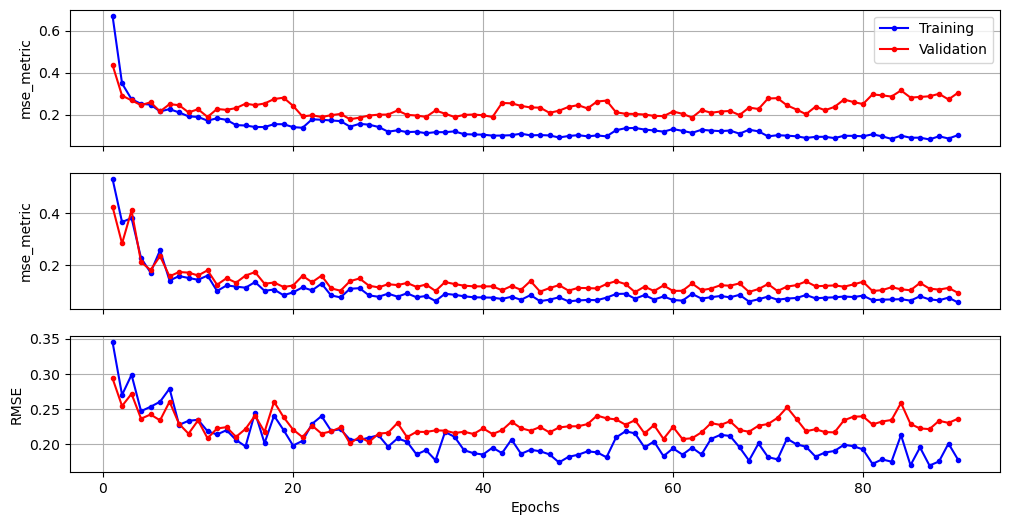

In [14]:
lepochs = list(range(1,params_train["num_epochs"] + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, sm_metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, sm_metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[0].set_ylabel(metric_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, sm_metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, sm_metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[1].set_ylabel(metric_fn.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [15]:
# save model
fp = dp_surrogate_model / f"{wflow_model}_{surrogate_experiment_name}_t{TARGET_INITIALS}_h{HIDDEN}.pt"
torch.save(model.state_dict(), fp)